# 2A.ml - Réduction d'une forêt aléatoire - correction

Le modèle Lasso permet de sélectionner des variables, une forêt aléatoire produit une prédiction comme étant la moyenne d'arbres de régression. Et si on mélangeait les deux ?

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Datasets

Comme il faut toujours des données, on prend ce jeu [Boston](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html).

In [3]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Une forêt aléatoire

In [5]:
from sklearn.ensemble import RandomForestRegressor as model_class
clr = model_class()
clr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Le nombre d'arbres est...

In [6]:
len(clr.estimators_)

100

In [7]:
from sklearn.metrics import r2_score
r2_score(y_test, clr.predict(X_test))

0.8816716443059919

## Random Forest = moyenne des prédictions

On recommence en faisant la moyenne soi-même.

In [8]:
import numpy
dest = numpy.zeros((X_test.shape[0], len(clr.estimators_)))
estimators = numpy.array(clr.estimators_).ravel()
for i, est in enumerate(estimators):
    pred = est.predict(X_test)
    dest[:, i] = pred

average = numpy.mean(dest, axis=1)
r2_score(y_test, average)

0.8816716443059919

A priori, c'est la même chose.

## Pondérer les arbres à l'aide d'une régression linéaire

La forêt aléatoire est une façon de créer de nouvelles features, 100 exactement qu'on utilise pour caler une régression linéaire.

In [9]:
from sklearn.linear_model import LinearRegression


def new_features(forest, X):
    dest = numpy.zeros((X.shape[0], len(forest.estimators_)))
    estimators = numpy.array(forest.estimators_).ravel()
    for i, est in enumerate(estimators):
        pred = est.predict(X)
        dest[:, i] = pred
    return dest


X_train_2 = new_features(clr, X_train)
lr = LinearRegression()
lr.fit(X_train_2, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
X_test_2 = new_features(clr, X_test)
r2_score(y_test, lr.predict(X_test_2))

0.8759826041035556

Un peu moins bien, un peu mieux, le risque d'overfitting est un peu plus grand avec ces nombreuses features car la base d'apprentissage ne contient que 379 observations (regardez ``X_train.shape`` pour vérifier).

In [11]:
lr.coef_

array([-0.01122904,  0.0044548 ,  0.04920393,  0.02824337, -0.04625929,
       -0.03198554,  0.04100134, -0.0110173 ,  0.02175922,  0.02270664,
       -0.07129658, -0.04025288,  0.01199426,  0.03317564,  0.0011403 ,
        0.03344571,  0.01945555, -0.03182884,  0.07348532,  0.00333813,
        0.02294959, -0.00464431,  0.0225264 ,  0.0119253 ,  0.09014915,
       -0.0376745 ,  0.04447262,  0.02850649,  0.00736921, -0.01369467,
        0.02986174,  0.00575564,  0.05044376,  0.02081299,  0.01798322,
       -0.00192326,  0.09159215,  0.08490833,  0.00953901,  0.05039408,
       -0.00231599, -0.03193621,  0.04187978, -0.01702496,  0.02467238,
        0.0180003 ,  0.08144923, -0.00251786, -0.01782545, -0.01027325,
        0.01990357, -0.03748182, -0.04099434,  0.00057383, -0.03013624,
        0.11380534,  0.06436785,  0.04228636,  0.02423566, -0.0560923 ,
       -0.03855099,  0.041692  ,  0.03862377,  0.08781796, -0.05300599,
       -0.00840021,  0.02812588, -0.01234117,  0.03544364,  0.01

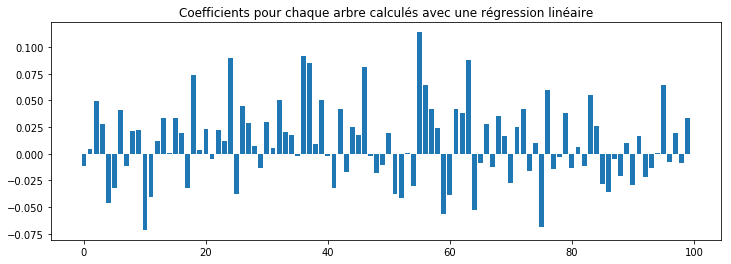

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.bar(numpy.arange(0, len(lr.coef_)), lr.coef_)
ax.set_title("Coefficients pour chaque arbre calculés avec une régression linéaire");

Le score est avec une régression linéaire sur les variables initiales est nettement moins élevé.

In [13]:
lr_raw = LinearRegression()
lr_raw.fit(X_train, y_train)
r2_score(y_test, lr_raw.predict(X_test))

0.6978615081037233

## Sélection d'arbres

L'idée est d'utiliser un algorithme de sélection de variables type [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) pour réduire la forêt aléatoire sans perdre en performance. C'est presque le même code.

In [14]:
from sklearn.linear_model import Lasso

lrs = Lasso(max_iter=10000)
lrs.fit(X_train_2, y_train)
lrs.coef_

array([0.        , 0.        , 0.02245791, 0.01210641, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03045497,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01150988, 0.00435434, 0.        , 0.03146978, 0.        ,
       0.        , 0.        , 0.03183664, 0.        , 0.12385294,
       0.        , 0.03312474, 0.        , 0.        , 0.        ,
       0.02413847, 0.        , 0.        , 0.        , 0.00498728,
       0.        , 0.06410314, 0.04747783, 0.        , 0.00633977,
       0.        , 0.        , 0.03690248, 0.        , 0.        ,
       0.        , 0.0564866 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05602663, 0.08840581, 0.01980571, 0.        , 0.        ,
       0.        , 0.02873135, 0.03756932, 0.05435875, 0.        ,
       0.        , 0.01786024, 0.        , 0.0597982 , 0.02132273,
       0.        , 0.        , 0.00315636, 0.        , 0.     

Pas mal de zéros donc pas mal d'arbres non utilisés.

In [15]:
r2_score(y_test, lrs.predict(X_test_2))

0.8843604495090776

Pas trop de perte... Ca donne envie d'essayer plusieurs valeur de `alpha`.

In [16]:
from tqdm import tqdm
alphas = [0.01 * i for i in range(100)] +[1 + 0.1 * i for i in range(100)]
obs = []
for i in tqdm(range(0, len(alphas))):
    alpha = alphas[i]
    lrs = Lasso(max_iter=20000, alpha=alpha)
    lrs.fit(X_train_2, y_train)
    obs.append(dict(
        alpha=alpha,
        null=len(lrs.coef_[lrs.coef_!=0]),
        r2=r2_score(y_test, lrs.predict(X_test_2))
    ))

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]c:\python372_x64\lib\site-packages\ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125.80123242096884, tolerance: 3.3705663218997364
  positive)
  0%|▍                                                                                 | 1/200 [00:00<01:53,  1.75it/s]C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\coordinate_des

In [17]:
from pandas import DataFrame
df = DataFrame(obs)
df.tail()

,alpha,null,r2
195,10.5,21,0.877512
196,10.6,21,0.877345
197,10.7,21,0.877175
198,10.8,21,0.877003
199,10.9,21,0.876827


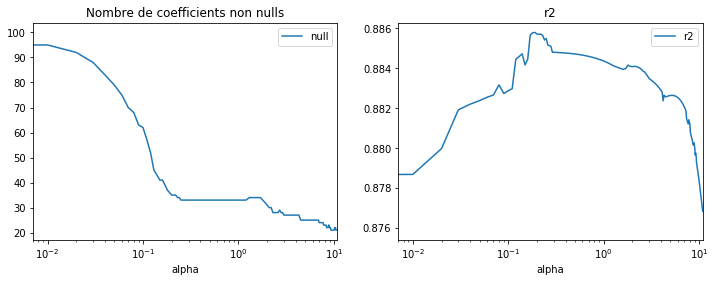

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
df[["alpha", "null"]].set_index("alpha").plot(ax=ax[0], logx=True)
ax[0].set_title("Nombre de coefficients non nulls")
df[["alpha", "r2"]].set_index("alpha").plot(ax=ax[1], logx=True)
ax[1].set_title("r2");

Dans ce cas, supprimer des arbres augmentent la performance, comme évoqué ci-dessus, cela réduit l'overfitting. Le nombre d'arbre peut être réduit des deux tiers avec ce modèle.